# Wine quality
[...]
Author: Albert Wildeman

CHECKS
- do not load unnecessary libraries

#JOIN DATASETS OR NOT? talk:
- A. all together, extra binary variable for red/white
- B. all separate (because requirements different for each - valid to try this first and see how similar models are)
- C. Bayesian hierarchical. Just 2 types is not much; would make more sense with say 4+

In [21]:
# Load libraries
import numpy as np
import pandas as pd
import scipy.stats as st
import copy

# SKLearn
from sklearn import preprocessing, svm, metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.feature_selection import RFECV

# Graphics
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(0)

# Load data

In [2]:
clrs  = ['red', 'white']
n_clrs = len(clrs)
dfs = [ pd.read_csv("data/winequality-" + clr + ".csv", sep = ';') for clr in clrs]

In [3]:
# See if the columns are identical for red and white wine
dfs[0].columns.identical(dfs[1].columns)

True

In [4]:
# Generate list of features
feats = dfs[0].drop('quality', axis=1).columns.values
# Get number of features &  (for each color) observations
n_feats = len(feats)

In [5]:
# Determine how many missing values there are
for i_clr, clr in enumerate(clrs):
    print('Missing values in ' + clr + ' wine data: ' + str(dfs[i_clr].isnull().sum().sum()))

Missing values in red wine data: 0
Missing values in white wine data: 0


In [6]:
# None! great news.

In [7]:
# plotting colors for red, white wine
plot_colors = [(0.65, 0, 0.10), (0.93, 0.96, 0.88)]

# Distribution of quality ratings and features

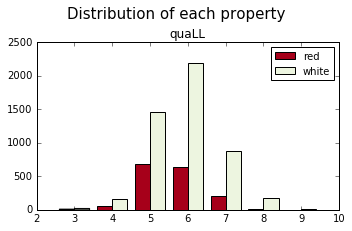

In [8]:
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
arr = ax.hist([df.quality.values for df in dfs], np.arange(2.5, 10.5), histtype='bar', color=plot_colors, label=clrs)
ax.legend(prop={'size': 10})
plt.title('quaLL')
st = plt.suptitle('Distribution of each property', size='15')
st.set_y(1.05) # place above subplots
plt.tight_layout();

In [9]:
def plot_histograms(dfs):
    fig = plt.figure(figsize=(15,5))
    for i_feat, feat in enumerate(feats):

        ax = plt.subplot2grid((3,4),divmod(i_feat,4))
        ax.hist([df[feat].values for df in dfs], 12, normed=1, histtype='bar', color=plot_colors, label=clrs)
        
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelleft='off')
        plt.title(feat)
        
    ax = plt.subplot2grid((3,4),(2,3))
    ax.hist([[0],[0]], color=plot_colors, label=clrs)
    ax.set_ylim(-2,-1)
    ax.axis('off')
    ax.legend(prop={'size': 10})
    st = plt.suptitle('Distribution of each property', size='15')
    st.set_y(1.05) # place above subplots
    plt.tight_layout();

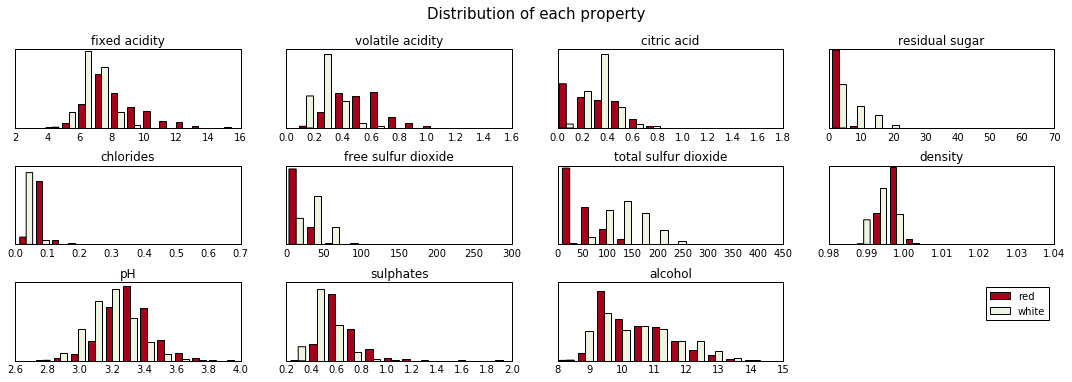

In [10]:
plot_histograms(dfs)

# Log scaling
Inspect distributions of all variables.

In [11]:
# Set features to log-transform
skewed_feats = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']
# log transform
for df in dfs:
    df[skewed_feats] = np.log1p(df[skewed_feats])

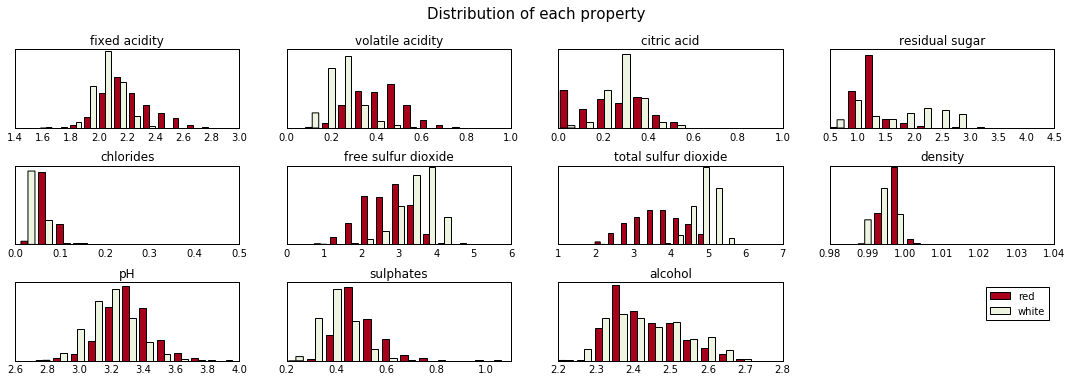

In [12]:
plot_histograms(dfs)

## Outliers

In [13]:
# Candidates for outliers:
inspect = ['chlorides','density']
for feat in inspect:
    for i_clr in range(n_clrs):
        print('5 largest values for ' + feat + ' (' + clrs[i_clr] + '): ', np.sort(dfs[i_clr][feat].values)[-5:])

5 largest values for chlorides (red):  [ 0.35206433  0.38117242  0.3832195   0.47623418  0.4768551 ]
5 largest values for chlorides (white):  [ 0.22713557  0.23980399  0.25464222  0.2631332   0.29713723]
5 largest values for density (red):  [ 1.00315  1.00315  1.0032   1.00369  1.00369]
5 largest values for density (white):  [ 1.00295  1.00295  1.0103   1.0103   1.03898]


Of these, the white wine with the largest value for density is the most concerning. Inspect the quality of this wine:

In [14]:
print('Quality of candidate for deletion: ', dfs[1].loc[np.where(dfs[1].density==1.03898)[0],'quality'].values[0])    

Quality of candidate for deletion:  6


This is neither poor nor excellent, and therefore not a particularly valuable datapoint. Delete:

In [15]:
dfs[1] = dfs[1].loc[np.where(dfs[1].density!=1.03898)[0],:]

## Normalization: mean-centering and variance scaling
One of the benefits of normalization is that it allows regularized linear models such as Lasso or Ridge Regression to penalize the various feautures evenly.

In [16]:
X = [preprocessing.StandardScaler().fit_transform(dfs[i_clr][feats]) for i_clr in range(n_clrs)]

# Prep data for ML
Split into training (2/3) and test (1/3) sets, and create feature matrices and target vectors as separate entities.

In [17]:
# target vector. poor (<5), excellent (>7)
y_multiclass = [df.quality.values for df in dfs]
y = [[(yy>7)*1 for yy in y_multiclass], 
     [(yy<5)*1 for yy in y_multiclass],]

criteria = ['excellent', 'poor']
n_criteria = len(criteria)

# Machine Learning

In [162]:
# Set up possible values of parameters to optimize over
p_grid = {"C": [.1, 1, 10],
          "gamma": [.01, .05, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svc = svm.SVC(kernel="linear", class_weight='balanced')

conf_matrices = [[None]*n_clrs]*n_criteria
feat_sel = pd.DataFrame(columns = feats, dtype=bool)
performance = pd.DataFrame(columns = ['recall', 'precision'])

for i_crit in range(n_criteria):
    for i_clr in range(n_clrs):
        
        selector = RFECV(estimator=svc,  scoring = 'recall')
        selector.fit(X[i_clr], y[i_crit][i_clr])
        feat_sel.loc[criteria[i_crit] + ' ' + clrs[i_clr], :] = selector.support_
        
        clf = GridSearchCV(estimator=svc, param_grid=p_grid, cv=3, scoring = 'recall')
        # Nested CV with parameter optimization
        predicted = cross_val_predict(clf, X[i_clr][:,selector.support_], y[i_crit][i_clr], cv=4)
#        print(metrics.confusion_matrix(y[i_crit][i_clr], predicted))
#        print(metrics.recall_score(y[i_crit][i_clr], predicted))
#        print(metrics.precision_score(y[i_crit][i_clr], predicted))
        
        performance.loc[criteria[i_crit] + ' ' + clrs[i_clr], :] = [metrics.recall_score(y[i_crit][i_clr], predicted),
                                                                    metrics.precision_score(y[i_crit][i_clr], predicted)]
        
feat_sel['selected features'] = (feat_sel*1).sum(axis=1) #Append column to show number of features used
feat_sel.loc['times incl.',:] = (feat_sel*1).sum(); feat_sel.ix['times incl.', 'selected features'] = ''
performance = performance.applymap(lambda x: str(int(round(x*100)))+'%')

[[1302  279]
 [   0   18]]
1.0
0.0606060606061
[[3140 1577]
 [  43  137]]
0.761111111111
0.0799299883314
[[1130  406]
 [  22   41]]
0.650793650794
0.0917225950783
[[3841  873]
 [  56  127]]
0.693989071038
0.127


In [163]:
performance

,recall,precision
excellent red,100%,6%
excellent white,76%,8%
poor red,65%,9%
poor white,69%,13%


In [164]:
feat_sel

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,selected features
excellent red,False,False,False,False,True,False,True,True,True,True,True,6
excellent white,False,False,False,False,False,False,False,False,False,False,True,1
poor red,True,True,True,True,True,True,True,True,True,False,True,10
poor white,False,True,False,True,False,True,False,True,False,False,False,4
times incl.,1,2,1,2,2,2,2,3,2,1,3,


# Clustering


# Do Dendrogram, big gap.


In [19]:
# do scaling like before, but now include quality
X_cl = [preprocessing.StandardScaler().fit_transform(dfs[i_clr]) for i_clr in range(n_clrs)]

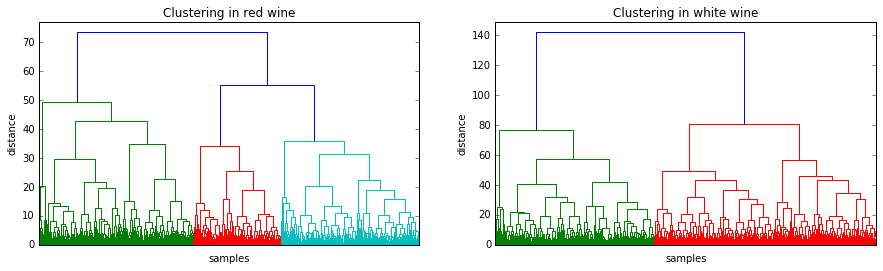

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
fig = plt.figure(figsize=(15,4))
for i_clr in range(n_clrs):
    Z = linkage(X_cl[i_clr], 'ward')
    ax = plt.subplot2grid((1,2),(0,i_clr))
    # calculate full dendrogram
    plt.title('Clustering in ' + clrs[i_clr] + ' wine')
    plt.xlabel('samples')
    plt.ylabel('distance')
    dendrogram(Z, leaf_label_func= lambda x : '')